# Homework 4: Classification
## Matt Oehler
___

## Table of Contents
1. Data
1. Modeling
1. Results
1. Acknowlegements

In [1]:
# import libraries
#for data manipulation
import pandas as pd
import numpy as np
from sklearn.preprocessing import  StandardScaler
from collections import Counter

#for data modeling
from sklearn import linear_model as lm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb

#model diagnostics and evaluation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report

#for visualization
from matplotlib import pyplot as plt
import seaborn as sns
from IPython.display import Image #display kaggle screenshots

#keep track of run time for more complicated models
from datetime import datetime, timedelta
import time

#notebook settings
pd.options.display.max_columns = None #show all columns for data set
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points


### DATA

In [2]:
#read in the raw train/test sets
train_raw = pd.read_csv('train.csv')
test_raw = pd.read_csv('test.csv')
print("Train:",train_raw.shape)
print("Test:",test_raw.shape)
train_raw.head()

Train: (9557, 143)
Test: (23856, 142)


,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,r4t3,tamhog,tamviv,escolari,rez_esc,hhsize,paredblolad,paredzocalo,paredpreb,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisocemento,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,techootro,cielorazo,abastaguadentro,abastaguafuera,abastaguano,public,planpri,noelec,coopele,sanitario1,sanitario2,sanitario3,sanitario5,sanitario6,energcocinar1,energcocinar2,energcocinar3,energcocinar4,elimbasu1,elimbasu2,elimbasu3,elimbasu4,elimbasu5,elimbasu6,epared1,epared2,epared3,etecho1,etecho2,etecho3,eviv1,eviv2,eviv3,dis,male,female,estadocivil1,estadocivil2,estadocivil3,estadocivil4,estadocivil5,estadocivil6,estadocivil7,parentesco1,parentesco2,parentesco3,parentesco4,parentesco5,parentesco6,parentesco7,parentesco8,parentesco9,parentesco10,parentesco11,parentesco12,idhogar,hogar_nin,hogar_adul,hogar_mayor,hogar_total,dependency,edjefe,edjefa,meaneduc,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9,bedrooms,overcrowding,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,mobilephone,qmobilephone,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,area2,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_279628684,190000.000,0,3,0,1,1,0,nan,0,1,1,0,0,0,0,1,1,1,1,10,nan,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,21eb7fcc1,0,1,0,1,no,10,no,10.000,0,0,0,1,0,0,0,0,0,1,1.000,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,43,100,1849,1,100,0,1.000,0.000,100.000,1849,4
1,ID_f29eb3ddd,135000.000,0,4,0,1,1,1,1.000,0,1,1,0,0,0,0,1,1,1,1,12,nan,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0e5d7a658,0,1,1,1,8,12,no,12.000,0,0,0,0,0,0,0,1,0,1,1.000,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,67,144,4489,1,144,0,1.000,64.000,144.000,4489,4
2,ID_68de51c94,nan,0,8,0,1,1,0,nan,0,0,0,0,1,1,0,1,1,1,1,11,nan,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,2c7317ea8,0,1,1,1,8,no,11,11.000,0,0,0,0,1,0,0,0,0,2,0.500,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,92,121,8464,1,0,0,0.250,64.000,121.000,8464,4
3,ID_d671db89c,180000.000,0,5,0,1,1,1,1.000,0,2,2,1,1,2,1,3,4,4,4,9,1.000,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,2b58d945f,2,2,0,4,yes,11,no,11.000,0,0,0,1,0,0,0,0,0,3,1.333,0,0,1,0,0,0,0,1,3,1,0,0,0,0,0,1,0,17,81,289,16,121,4,1.778,1.000,121.000,289,4
4,ID_d56d6f5f5,180000.000,0,5,0,1,1,1,1.000,0,2,2,1,1,2,1,3,4,4,4,11,nan,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2b58d945f,2,2,0,4,yes,11,no,11.000,0,0,0,0,1,0,0,0,0,3,1.333,0,0,1,0,0,0,0,1,3,1,0,0,0,0,0,1,0,37,121,1369,16,121,4,1.778,1.000,121.000,1369,4


It's interesting to note that the test set is much larger than the train set for this problem.

In [3]:
#concatenate the train and test sets for data cleaning
data = train_raw

Based on the data descriptions, there are certain variables (which I could describe better if I knew Spanish) that can be derived from each other based on a handful of conditions. We can use this information to make a single education column that is independent of a specified gender.

In [4]:
# #look at which columns have missing values and how many
# #columns with no missing values were omitted
# print("Number of missing values for each column:")
# has_missing_vals = [x for x in df.columns if data[x].isnull().sum() > 0]
# data[has_missing_vals].isnull().sum()

In [5]:
a = type(data["Id"][0])
is_object = [i for i in df.columns if type(df[i][0]) == a]
is_object


NameError: name 'df' is not defined

In [ ]:
#drop columns with missing values for now
# data.drop(has_missing_vals + is_object, axis = 1, inplace = True)

In [6]:
# #how many observations out of 480 are incomplete
print("Observations with missing values: ",sum([True for idx,row in train_raw.iterrows() if any(row.isnull())]))
print("Total Observations: ", train_raw.shape[0])
# #plot of missing values
# sns.heatmap(train_raw.isnull(),cbar=False)
# plt.title("Plot of Missing Values")
# plt.ylabel('Index', fontsize=13)
# sns.despine()

Observations with missing values:  9401
Total Observations:  9557


In [7]:
conditions = [
    (data['edjefe']=='no') & (data['edjefa']=='no'), #both no
    (data['edjefe']=='yes') & (data['edjefa']=='no'), # yes and no
    (data['edjefe']=='no') & (data['edjefa']=='yes'), #no and yes 
    (data['edjefe']!='no') & (data['edjefe']!='yes') & (data['edjefa']=='no'), # number and no
    (data['edjefe']=='no') & (data['edjefa']!='no') # no and number
]
choices = [0, 1, 1, data['edjefe'], data['edjefa']]
data['edjefx']=np.select(conditions, choices)
data['edjefx']=data['edjefx'].astype(int)
data[['edjefe', 'edjefa', 'edjefx']][:15]

,edjefe,edjefa,edjefx
0,10,no,10
1,12,no,12
2,no,11,11
3,11,no,11
4,11,no,11
5,11,no,11
6,11,no,11
7,9,no,9
8,9,no,9
9,9,no,9


In [8]:
#now we take a gander to see if there are missing values
data.columns[data.isna().sum()!=0]


Index(['v2a1', 'v18q1', 'rez_esc', 'meaneduc', 'SQBmeaned'], dtype='object')

In [9]:
#for the households with young people we put fill in there missing education values
meaneduc_nan=data[data['meaneduc'].isnull()][['Id','idhogar','escolari']]
me=meaneduc_nan.groupby('idhogar')['escolari'].mean().reset_index()
for row in meaneduc_nan.iterrows():
    idx=row[0]
    idhogar=row[1]['idhogar']
    m=me[me['idhogar']==idhogar]['escolari'].tolist()[0]
    data.at[idx, 'meaneduc']=m
    data.at[idx, 'SQBmeaned']=m*m
    
#we assume that the missing values for monthly rent imply that they own their houses (monthly rent == 0)
data['v2a1']=data['v2a1'].fillna(0)

#if there is a missing value for the tablet column it means they don't own a tablet => 0
data['v18q1']=data['v18q1'].fillna(0)

#missing values for years behind in school are all associated with adults or small children
data['rez_esc']=data['rez_esc'].fillna(0)


In [10]:
# Apparently some houses have multiple classes associated with them
d={}
weird=[]
for row in data.iterrows():
    idhogar=row[1]['idhogar']
    target=row[1]['Target']
    if idhogar in d:
        if d[idhogar]!=target:
            weird.append(idhogar)
    else:
        d[idhogar]=target
len(set(weird))

85

In [11]:
# we change these weird cases to match the head of the household
for i in set(weird):
    hhold=data[data['idhogar']==i][['idhogar', 'parentesco1', 'Target']]
    target=hhold[hhold['parentesco1']==1]['Target'].tolist()[0]
    for row in hhold.iterrows():
        idx=row[0]
        if row[1]['parentesco1']!=1:
            data.at[idx, 'Target']=target
    

All of the data cleaning steps can be mapped to a single function which is really nice in case we were to gain access to new data, we would be able to clean it easily.

In [12]:
def data_cleaning(data):
    data['dependency']=np.sqrt(data['SQBdependency'])
    data['rez_esc']=data['rez_esc'].fillna(0)
    data['v18q1']=data['v18q1'].fillna(0)
    data['v2a1']=data['v2a1'].fillna(0)
    
    conditions = [
    (data['edjefe']=='no') & (data['edjefa']=='no'), #both no
    (data['edjefe']=='yes') & (data['edjefa']=='no'), # yes and no
    (data['edjefe']=='no') & (data['edjefa']=='yes'), #no and yes 
    (data['edjefe']!='no') & (data['edjefe']!='yes') & (data['edjefa']=='no'), # number and no
    (data['edjefe']=='no') & (data['edjefa']!='no') # no and number
    ]
    choices = [0, 1, 1, data['edjefe'], data['edjefa']]
    data['edjefx']=np.select(conditions, choices)
    data['edjefx']=data['edjefx'].astype(int)
    data.drop(['edjefe', 'edjefa'], axis=1, inplace=True)
    
    meaneduc_nan=data[data['meaneduc'].isnull()][['Id','idhogar','escolari']]
    me=meaneduc_nan.groupby('idhogar')['escolari'].mean().reset_index()
    for row in meaneduc_nan.iterrows():
        idx=row[0]
        idhogar=row[1]['idhogar']
        m=me[me['idhogar']==idhogar]['escolari'].tolist()[0]
        data.at[idx, 'meaneduc']=m
        data.at[idx, 'SQBmeaned']=m*m
        
    return data

In [13]:
df_train = data_cleaning(train_raw)
df_test = data_cleaning(test_raw)
print(df_train.shape)
print(df_test.shape)
#Since we don't submit to kaggle for this hw, I will be ignoring the test set, and just using a subset of
#the training set to assess model performance

(9557, 142)
(23856, 141)


Next we can check to see how our response variable is distributed. We can see that most of the data are considered to be class 4.

Counts of Response Variable
4    6004
2    1558
3    1221
1     774
Name: Target, dtype: int64


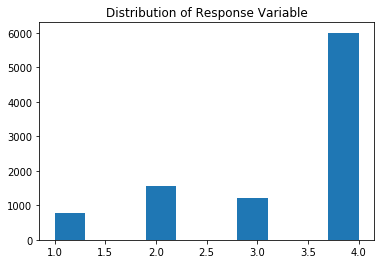

In [14]:
print("Counts of Response Variable")
print(df_train.Target.value_counts())
plt.hist(df_train.Target)
plt.title("Distribution of Response Variable")
plt.show()

We can use a technique called undersampling to artificially balance the data. We randomly sample from the observations where the response is 4 until we get an amount that is approximately balanced with the amount of observations for the other 3 classes.  This method should probably by rationalized by doing sufficient cross validation with undersampled data sets so that we don't lose important information in general from non-sampled data. Another approach would be to oversample the smaller classes, but since they are in the majority here, we will just undersample the one oversized class.

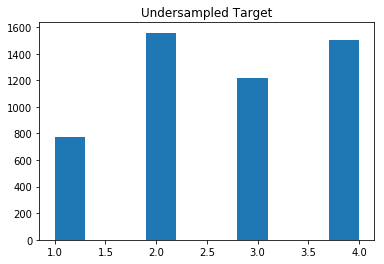

In [15]:
data_undersampled=data.drop(data.query('Target == 4').sample(frac=.75).index)
plt.hist(data_undersampled.Target)
plt.title("Undersampled Target")
plt.show()

## Modeling
First I will try a Random Forest

In [21]:
#get rid of useless columns and undersample the response variable
# X=data_undersampled.drop(['Id', 'idhogar', 'Target', 'edjefe', 'edjefa','dependency'], axis=1)
X=data_undersampled.drop(['Id', 'idhogar', 'Target','dependency'], axis=1)
y=data_undersampled['Target']


In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [23]:
#set up grid search for Random Forest
clf = RandomForestClassifier()
params={'n_estimators': list(range(40,61, 1))}
gs = GridSearchCV(clf, params, cv=5)

start = time.time()
gs.fit(X_train, y_train)
end = time.time()
print("Search Time: ", round((end - start)), "seconds")
print("Best Params: {}".format(gs.best_params_))

preds=gs.predict(X_test)
print(classification_report(y_test, preds))

Search Time:  77 seconds
Best Params: {'n_estimators': 59}
             precision    recall  f1-score   support

          1       0.96      0.89      0.93       139
          2       0.85      0.92      0.88       302
          3       0.89      0.90      0.90       250
          4       0.88      0.84      0.86       320

avg / total       0.89      0.89      0.89      1011



Those reults don't seem too bad!

Next I will try to using K Nearest Neighbors to classify. They didn't seem to do nearly as well as Random Forrests did

In [29]:
model = KNeighborsClassifier()
params = {"n_neighbors": [2,4,8,10,20, 50, 100], "weights": ['uniform','distance']}
gridsearch = GridSearchCV(model, params, cv = 3)
a = time.time()
gridsearch.fit(X_train, y_train)
preds = gridsearch.predict(X_test)
b = time.time()
print("Search Time: ", round((b - a)), "seconds")
print("Best Params: {}".format(gridsearch.best_params_))

preds=gridsearch.predict(X_test)
print(classification_report(y_test, preds))

Search Time:  28 seconds
Best Params: {'n_neighbors': 50, 'weights': 'distance'}
             precision    recall  f1-score   support

          1       0.41      0.24      0.30       139
          2       0.40      0.63      0.49       302
          3       0.38      0.24      0.29       250
          4       0.55      0.52      0.53       320

avg / total       0.45      0.44      0.43      1011



Lastly I will try Support Vector Machines.
The gridsearch time for Support Vector Machines was significantly longer. 

In [31]:
model = SVC()
gridsearch = GridSearchCV(model, {"kernel": ['rbf'], "C": [0.1,1], 
                                'gamma': ['auto', 0.01]}, cv = 3)
a = time.time()
gridsearch.fit(X_train, y_train)
preds = gridsearch.predict(X_test)
b = time.time()
print("Search Time: ", round((b - a)), "seconds")
print("Best Params: {}".format(gridsearch.best_params_))

preds=gridsearch.predict(X_test)
print(classification_report(y_test, preds))

Search Time:  98 seconds
Best Params: {'C': 0.1, 'gamma': 'auto', 'kernel': 'rbf'}
             precision    recall  f1-score   support

          1       0.00      0.00      0.00       139
          2       0.30      1.00      0.46       302
          3       0.00      0.00      0.00       250
          4       0.00      0.00      0.00       320

avg / total       0.09      0.30      0.14      1011



C:\Users\Matt\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Of the models that I tried it seems that Random Forrest performed best. KNN was the fastest to run, but it didn't even come close to performing as well as the others. SVM took by far the longest amount of time to train (probably since the data has so many dimensions), and it still didn't quite outperform the random forest model.

## Acknowledgements
These kaggle kernels provided great insight into how to clean and model the data:
- [Data Cleaning](https://www.kaggle.com/katacs/data-cleaning-and-random-forest)
- [The Legendary Lecture Notebooks of Tyler Folkman](https://github.com/tfolkman/byu_econ_applied_machine_learning/tree/master/lectures)
